In [1]:
pip install -q -U keras_tuner

     |████████████████████████████████| 98 kB 4.0 MB/s 


In [57]:
# Import libraries
import sys, glob, os, time
import numpy as np
import scipy as sp
import pandas as pd
from csv import reader, writer
import joblib
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Activation, Input, Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, UpSampling2D, Reshape, LeakyReLU
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.generic_utils import get_custom_objects
import keras_tuner as kt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython import display

get_custom_objects().update({'leaky-relu': Activation(LeakyReLU(alpha=0.2))})

In [3]:
# Activate GPU
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
# current working directory
cwd = '/content/drive/MyDrive/Colab Notebooks/Daylight Autonomy/'

# Data setup

In [5]:
features_file = os.path.join(cwd, 'data', 'features.csv')
targets_file = os.path.join(cwd, 'data', 'targets.csv')

In [6]:
raw_features = pd.read_csv(features_file, index_col=0)
raw_targets = pd.read_csv(targets_file)

In [7]:
minmax = np.array([[-10,10], [-10,10], [-10,10], [-10,10],
                   [-10,10], [-10,10], [-10,10], [-10,10],
                   [2,5], [0.2,0.95], [0.2,0.95], [0,360]])

In [8]:
f_avg = minmax.mean(axis=1)
f_std = minmax.std(axis=1)
t_std = 1

features = (raw_features - f_avg)/f_std
targets = raw_targets/t_std

In [9]:
features = np.array(features)
targets = np.array(targets).reshape(len(targets),40,40)

In [10]:
# Split data to train, validate, test set (60% training, 20% validation, 20% test split)
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=98)

In [11]:
n_feat = features.shape[1]
n_tar = targets.shape[1]

# Model and training

In [98]:
# Clear keras workspace for new model
keras.backend.clear_session()

# Deconvolutional Neural Network Model (DCNN) for generating daylight autonomy
model = Sequential()

### DNN model to analysis the input parameters
model.add(Dense(32 * 6 * 6, input_dim=n_feat))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(256 * 6 * 6))
model.add(BatchNormalization())
model.add(LeakyReLU())

### Deconvolution to generate image
model.add(Reshape((6, 6, 256)))

model.add(Conv2DTranspose(filters=128, kernel_size=6, strides=(2,2), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=64, kernel_size=6, strides=(2,2), activation='leaky-relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=1, kernel_size=5, strides=(1,1)))

# optimizer
model.compile(optimizer=optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999), loss="mse")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1152)              14976     
                                                                 
 batch_normalization (BatchN  (None, 1152)             4608      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1152)              0         
                                                                 
 dense_1 (Dense)             (None, 9216)              10626048  
                                                                 
 batch_normalization_1 (Batc  (None, 9216)             36864     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 9216)              0

In [99]:
class GenerateImage(keras.callbacks.Callback):
    def __init__(self, test_inputs):
        self.test_inputs = test_inputs
    
    def on_epoch_end(self, epoch, logs={}):
        predictions = self.model.predict(self.test_inputs)

        fig = plt.figure(figsize=(6,6))
        display.clear_output(wait=True)

        for i in range(predictions.shape[0]):
            plt.subplot(2,2,i+1)
            plt.imshow(predictions[i,:,:,0], cmap='RdYlBu_r', vmin=0, vmax=100)
            plt.axis('off')
        
        # plt.savefig(os.path.join(cwd, 'images', 'generated_img', 'image_at_epoch_{:04d}.png'.format(epoch)))
        plt.show()
        plt.close()

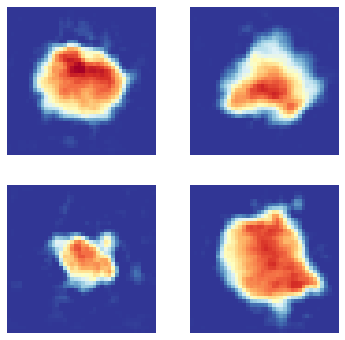

60/60 [==============================] - 1s 12ms/step - loss: 84.4131 - val_loss: 147.9451


In [100]:
history = model.fit(
    X_train,
    y_train,
    epochs = 200,
    batch_size = 16,
    validation_data = (X_val, y_val),
    # verbose=0,
    callbacks = [
                 EarlyStopping(monitor='val_loss', patience=100, mode='min'),
                 ModelCheckpoint(filepath = 'CNN2D.ckpt', save_weights_only=True, monitor='val_loss', save_best_only=True),
                 GenerateImage(X_test[[5,16,58,90]])
    ]
)

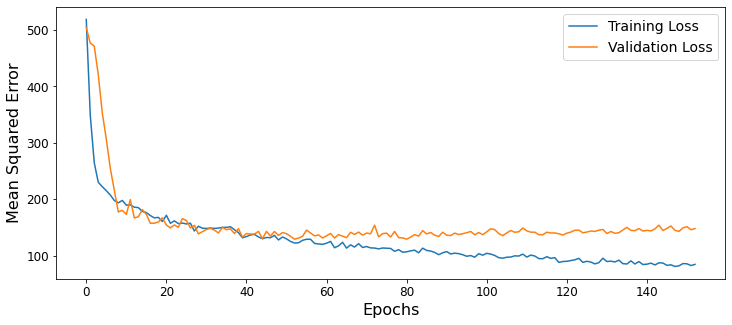

In [101]:
plt.figure(figsize=(12,5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.ylabel('Mean Squared Error',fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.legend(fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.show()

In [15]:
model.load_weights('CNN2D.ckpt');

In [17]:
y_pred = model.predict(X_test)
np.sqrt(mean_squared_error(y_test.reshape(-1, 40*40), y_pred.reshape(-1, 40*40)))

11.510778211019538

In [16]:
0.12790170316022087

0.12790170316022087

In [32]:
k = 255
q = 150

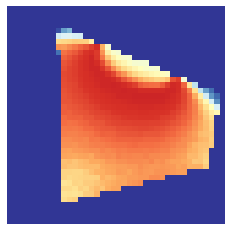

In [33]:
plt.imshow(y_test[k], cmap='RdYlBu_r', vmax=100, vmin=0)
plt.axis('off');

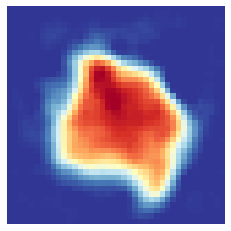

In [34]:
plt.imshow(y_pred[k].reshape(40,-1), cmap='RdYlBu_r', vmax=100, vmin=0)
plt.axis('off');

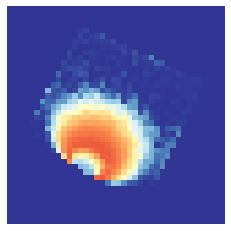

In [23]:
plt.imshow(y_train[q], cmap='RdYlBu_r', vmax=100, vmin=0)
plt.axis('off');

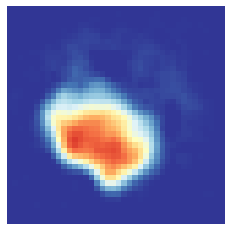

In [24]:
y_train_pred = model.predict(X_train)
plt.imshow(y_train_pred[q].reshape(40,-1), cmap='RdYlBu_r', vmax=100, vmin=0)
plt.axis('off');

In [25]:
np.sqrt(mean_squared_error(y_test[k],y_pred[k].reshape(40,-1)))

4.804962716826165

In [26]:
results = [np.sqrt(mean_squared_error(y_test[k],y_pred[k].reshape(40,-1))) for k in range(len(y_test))]    

In [27]:
# best result
results.index(min(results))

117

In [28]:
# worst result
results.index(max(results))

255

#Hyperparameter Tuning

In [ ]:
def construct_layers(hp,n_inputs, filter_size):
    layers = []
    out = n_inputs
    i = 1
    act_fct = hp.Choice('activation', values=['relu', 'selu', 'leaky-relu'])

    while out < 40:
        # if out < 16:
        #     ins = {"input":out,
        #         "kernel":hp.Choice('kernel_' + str(i), values = [3,5,7,9]),
        #         "stride":hp.Choice('stride_' + str(i), values = [1,2])}
        if out < 33:
            ins = {"input":out,
                "kernel":hp.Choice('kernel_' + str(i), values = [3,5,7,9]),
                "stride":1,
                "activation":act_fct
                }
        else:
            ins = {"input":out,
                "kernel":41 - out,
                "stride":1,
                "activation":'None'}
        out = (out-1) * ins["stride"] + ins["kernel"]
        i += 1
        ins.update({"output":out})
        layers.append(ins)

    layers[-1]["filter"] = 1

    for ly in reversed(layers[:-1]):
        ly.update({"filter":filter_size})
        filter_size = int(filter_size*2 if filter_size<120 else filter_size)
    
    return layers

In [ ]:
def generator(hp):
    # Deconvolutional Neural Network Model (DCNN) for generating daylight autonomy
    model = Sequential()

    # Construct CNN transpose layers
    hp_initsize = hp.Int('init_size', min_value=5, max_value=9)
    hp_minfilter = hp.Int('filter_size', min_value=10, max_value=20)

    CNN_layers = construct_layers(hp, hp_initsize, hp_minfilter)

    ### DNN model to analysis the input parameters
    model.add(Dense(CNN_layers[0]["filter"] * hp_initsize * hp_initsize, input_dim=12))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    ### Deconvolution to generate image
    model.add(Reshape((hp_initsize, hp_initsize, CNN_layers[0]["filter"])))

    for layer in CNN_layers[:-1]:
        model.add(Conv2DTranspose(filters=layer["filter"],
                                  kernel_size=layer["kernel"],
                                  strides=(layer["stride"],layer["stride"]),
                                  activation=layer["activation"]))
        model.add(BatchNormalization())
    
    model.add(Conv2DTranspose(filters=CNN_layers[-1]["filter"],
                              kernel_size=CNN_layers[-1]["kernel"],
                              strides=(CNN_layers[-1]["stride"],CNN_layers[-1]["stride"])
                              # , activation='sigmoid'
                              ))

    # optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
    hp_epsilon = hp.Choice('epsilon', values=[1e-5, 1e-7])
    model.compile(optimizer=optimizers.Adam(learning_rate=hp_learning_rate, 
                                            beta_1=0.9, beta_2=0.999,
                                            epsilon=hp_epsilon), 
                  loss="mse",
                #   metrics=['mse']
                  )

    return model

In [ ]:
keras.backend.clear_session()

In [ ]:
hp = kt.HyperParameters()
hp.values["model_type"] = "cnn"

model = generator(hp)
model(X_train)
model.summary()

In [ ]:
tuner = kt.RandomSearch(generator,
                        objective='val_loss', 
                        max_trials=200,
                        overwrite=True)

In [ ]:
tuner.search(X_train,
             y_train,
             epochs = 50,
             batch_size = 16,
             validation_data = (X_val, y_val),
             callbacks=[keras.callbacks.TensorBoard("/tmp/tb_logs")],
             )

Trial 1 Complete [00h 01m 44s]
val_loss: 0.01921738125383854

Best val_loss So Far: 0.01921738125383854
Total elapsed time: 00h 01m 44s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_model = tuner.get_best_models()[0]

In [ ]:
best_model.fit(X_train,
             y_train,
             epochs = 500,
             batch_size = 16,
             validation_data = (X_val, y_val),
             callbacks = [EarlyStopping(monitor='val_loss', patience=50, mode='min'),
                          ModelCheckpoint(filepath = 'CNN2D.ckpt', save_weights_only=True, monitor='val_loss', save_best_only=True)])

Epoch 1/25
38/38 [==============================] - 2s 65ms/step - loss: 0.0175 - val_loss: 0.0161
Epoch 2/25
38/38 [==============================] - 2s 44ms/step - loss: 0.0174 - val_loss: 0.0177
Epoch 3/25
38/38 [==============================] - 2s 47ms/step - loss: 0.0183 - val_loss: 0.0184
Epoch 4/25
38/38 [==============================] - 2s 40ms/step - loss: 0.0176 - val_loss: 0.0171
Epoch 5/25
38/38 [==============================] - 1s 39ms/step - loss: 0.0179 - val_loss: 0.0188
Epoch 6/25
38/38 [==============================] - 2s 43ms/step - loss: 0.0178 - val_loss: 0.0169


In [ ]:
best_model.load_weights('CNN2D.ckpt');

In [ ]:
y_pred = best_model.predict(X_test)
y_train_pred = best_model.predict(X_train)

In [ ]:
def compare_plot(sim, pred):
    results = [np.sqrt(mean_squared_error(sim[k],pred[k].reshape(40,-1))) for k in range(len(sim))]

    best_mse = min(results)
    best_idx = results.index(best_mse)

    worst_mse = max(results)
    worst_idx = results.index(worst_mse)

    fig, ax = plt.subplots(2,2,sharex=True, sharey=True, figsize=(7,7))

    ax[0,0].imshow(sim[best_idx], cmap='RdYlBu_r', vmax=1, vmin=0)
    ax[0,0].set_title('Simulation', size=15)
    ax[0,0].set_ylabel('Best Case: MSE={:.3f}'.format(best_mse), size=15)

    ax[0,1].imshow(pred[best_idx].reshape(40,-1), cmap='RdYlBu_r', vmax=1, vmin=0)
    ax[0,1].set_title('Prediction', size=15)

    ax[1,0].imshow(sim[worst_idx], cmap='RdYlBu_r', vmax=1, vmin=0)
    ax[1,0].set_ylabel('Worst Case: MSE={:.3f}'.format(worst_mse), size=15)

    ax[1,1].imshow(pred[worst_idx].reshape(40,-1), cmap='RdYlBu_r', vmax=1, vmin=0)

    ax=ax.ravel()
    for a in ax:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.set_xticks([])
        a.set_yticks([])

    plt.tight_layout()

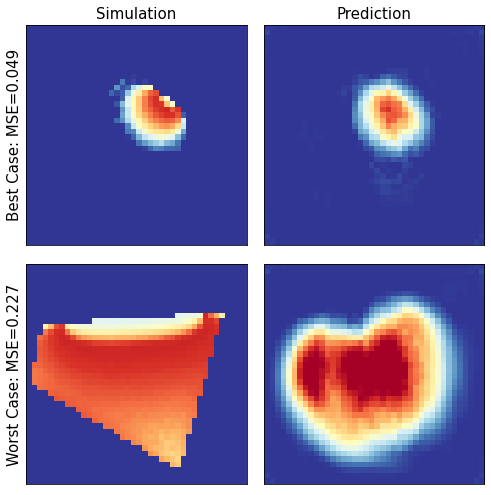

In [ ]:
compare_plot(y_test, y_pred)

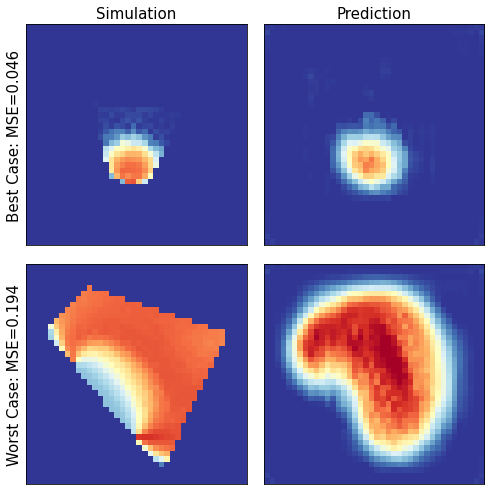

In [ ]:
compare_plot(y_train, y_train_pred)

In [ ]:
%load_ext tensorboard

%tensorboard --logdir /tmp/tb_logs

# Save model

In [ ]:
json = os.path.join(cwd, 'models/UDI_CNN.json')
hdf5 = os.path.join(cwd, 'models/UDI_CNN.h5')

model_json = model.to_json()
with open(json,'w') as json_file:
    json_file.write(model_json)
model.save_weights(hdf5)

# Test for random input

In [ ]:
test_case = np.array([4.7,8,6,9.52,2.87,1.25,180,45])

test_pred = model.predict(np.expand_dims(test_case, axis=0))[0].reshape(1,-1)

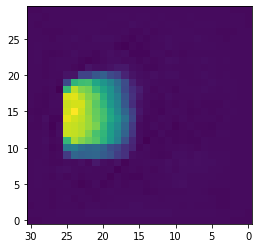

In [ ]:
plt.imshow(test_pred.reshape(30,-1))
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()